In [1]:
import sys
import os
sys.path.append(os.getcwd())

import datetime
import h5py as h5
import numpy as np
import pandas as pd
import utils

from obspy.core import UTCDateTime as udt
import matplotlib.pyplot as plt
import fast_matched_filter as fmf
from time import time as give_time
import obspy as obs
# to recognize the user
import getpass


Matched-filter GPU is not compiled! Should be here: /home/sanchezh/anaconda3/envs/fmf/lib/python3.7/site-packages/fast_matched_filter/lib/matched_filter_GPU.so


In [2]:
# generate a list with dates to loop over 
start_date_for_loop = '2022-05-26'
end_date_for_loop = '2022-05-27'

# set arguments for fmf
matched_filter_step = 1 # if set to 1, the sliding windows are taken every sample
architecture = 'cpu' # run fmf on GPUs (other option is 'cpu')
print_intermediate_step = True
save_intermediate_plots = True
merge_cc_sum_now = False



In [3]:
magnitude_date_time_eq = '2022-05-26T12:02:23.000000'

path = '/home/sanchezh/Desktop/PEROU/'
path_splitted_continuous_data =  path + 'data/waveforms/waveforms_'
path_template = path+'data/templates/' + magnitude_date_time_eq+'.hdf5'
path_cc_sum = path+'data/output/cc_sums/'
path_new_detection = path+'data/output/detections/'
path_for_plots = path+'data/output/plots/'

template = utils.load_template(path_template)

# format the inputs for fmf by adding a new dimension
# with 1 element (because this example only uses one template)
template_array = template['waveforms'][np.newaxis, :]


moveouts = np.hstack( (template['moveouts_S'].reshape(-1, 1),
                       template['moveouts_S'].reshape(-1, 1),
                       template['moveouts_P'].reshape(-1, 1)) )
moveout_array = moveouts[np.newaxis, :]

# fmf requires a weight matrix used to compute the weighted correlation
# coefficient sum
weight_array = np.ones_like(moveout_array, dtype=np.float32)
n_stations = weight_array.shape[1]
n_components = weight_array.shape[2]
# normalize so that the max value is 1 (optional)
weight_array /= np.float32(n_stations * n_components)

if print_intermediate_step==True:
    print('Shape of the weight array: ', weight_array.shape)
    print('Shape of the moveout array: ', moveout_array.shape)
    print('Shape of the template array: ', template_array.shape)

Shape of the weight array:  (1, 3, 3)
Shape of the moveout array:  (1, 3, 3)
Shape of the template array:  (1, 3, 3, 100)


In [4]:
# dates to loop
start_date_to_loop = datetime.datetime.strptime(start_date_for_loop, '%Y-%m-%d')
end_date_to_loop = datetime.datetime.strptime(end_date_for_loop, '%Y-%m-%d')
date_generated = [start_date_to_loop + datetime.timedelta(days=x) for x in range(0,(end_date_to_loop-start_date_to_loop).days)]
dates_to_loop_over = []

for date in date_generated:
    date = date.strftime('%Y-%m-%d')
    dates_to_loop_over.append(date)
time_range = dates_to_loop_over[0]+'_'+dates_to_loop_over[-1]

print(dates_to_loop_over)


['2022-05-26']


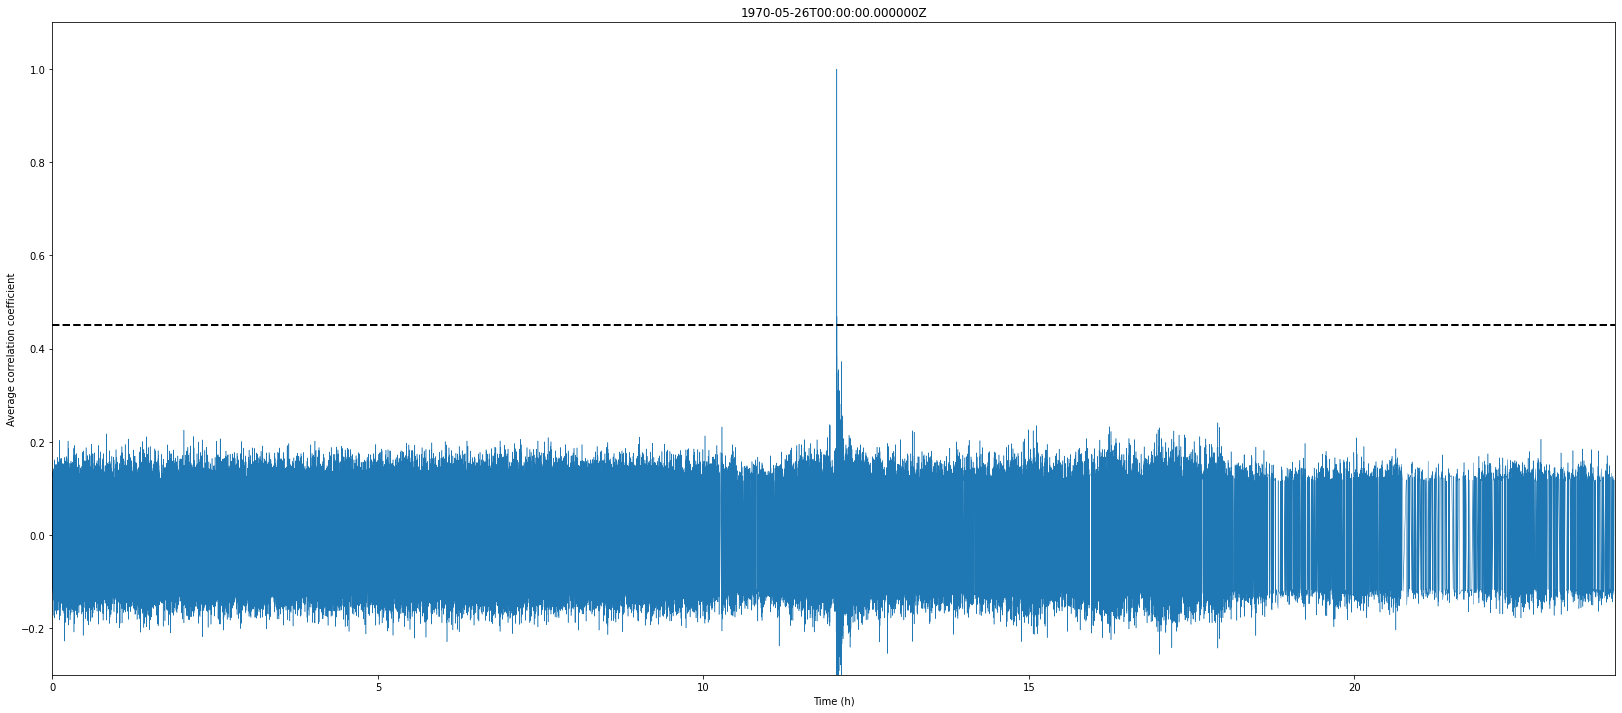

metadata and waveforms are Python lists with lengths 1 and 1        (respectively) because we use a single template.

Elements of metadata are dictionaries with information on:
 ['template_id', 'stations', 'components', 'origin_times', 'correlation_coefficients']


Elements of waveforms are numpy arrays with shape:
 (14, 3, 3, 3000)
14 events detected with Template 0


/home/sanchezh/anaconda3/envs/fmf/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchezh/anaconda3/envs/fmf/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [5]:
### calculate the fast matched filtering
#cc_sum_all 
#nr_templates = 0
#print(weight_array)
n_mad = 9

for i in range(len(dates_to_loop_over)):
    data = utils.load_data(path_splitted_continuous_data+dates_to_loop_over[i]+'.hdf5')

    cc_sum = fmf.matched_filter(template_array,
                                moveout_array,
                                weight_array,
                                data['waveforms'],
                                matched_filter_step,
                                arch=architecture)
    # merge all cc_sums directly
    if merge_cc_sum_now == True:
        if i ==0:
            cc_sum_all = np.zeros((nr_templates, np.shape(cc_sum)[1]*len(dates_to_loop_over)))

        cc_sum_all[i*np.shape(cc_sum)[1]:(i+1)*np.shape(cc_sum)[1]] = cc_sum
        #print(type(cc_sum))


        with h5.File(path_cc_sum+'merged.hdf5', mode='w') as f:
        #with h5.File(path_cc_sum+'TEEEST'+'.hdf5', mode='w') as f:
            f.create_dataset('cc_sum', data=cc_sum_all,compression='gzip')
                #f.close()
    with h5.File(path_cc_sum+magnitude_date_time_eq+'_'+dates_to_loop_over[i]+'.hdf5', mode='w') as f:
        #with h5.File(path_cc_sum+'TEEEST'+'.hdf5', mode='w') as f:
        f.create_dataset('cc_sum', data=cc_sum,compression='gzip')


    if save_intermediate_plots==True:
        # plot the cc time series
        figsize = (28, 12)
        plt.figure('cc_sum', figsize=figsize)
        time = np.linspace(0., float(cc_sum.shape[1]) / data['metadata']['sampling_rate'], cc_sum.shape[1])
        smart_plot = np.abs(cc_sum[0, :]) > 2.5 * np.std(cc_sum[0, :])
        plt.plot(time[smart_plot]/3600, cc_sum[0, smart_plot], lw=0.5)
        #plt.plot(datelist, cc_sum[0,:], lw=0.5)
        plt.axhline(0.45, lw=2, ls='--', color='k')
        plt.xlabel('Time (h)')
        plt.ylabel('Average correlation coefficient')
        plt.ylim(-0.3, 1.1)
        plt.xlim(time.min(), time.max()/3600)
        plt.title(data['metadata']['date'])
        #plt.savefig(path_for_plots+'cc_sum_plots/'+magnitude_date_time_eq+'_'+dates_to_loop_over[i]+'_correlation_coefficients.png')
        font = {'family': 'serif',
        'size': 18}
        plt.rc('font', **font)
        plt.show()

    moveouts = np.hstack( (template['moveouts_S'].reshape(-1, 1),
                       template['moveouts_S'].reshape(-1, 1),
                       template['moveouts_P'].reshape(-1, 1)) )
    moveout_array = moveouts[np.newaxis, :]

    metadata, waveforms = utils.extract_new_detections(data, cc_sum, moveout_array, n_mad=n_mad)

    reference_time = udt("2022-01-01T00:00:0.00").timestamp
    for t_id in range(len(metadata)):
        for orig in range(len(metadata[t_id]['origin_times'])):
            metadata[t_id]['origin_times'][orig] =  metadata[t_id]['origin_times'][orig] + reference_time
            #print(udt(metadata[t_id]['origin_times'][orig]))        
    
    #print(metadata)
    if print_intermediate_step==True:
        print('metadata and waveforms are Python lists with lengths {:d} and {:d}\
        (respectively) because we use a single template.\n'.format(len(metadata), len(waveforms)))
        print('Elements of metadata are dictionaries with information on:\n', list(metadata[0].keys()))
        print('\n')
        print('Elements of waveforms are numpy arrays with shape:\n', waveforms[0]['waveforms'].shape)
    utils.write_new_detections(magnitude_date_time_eq+'_'+dates_to_loop_over[i]+'_{:d}_mad'.format(int(n_mad)), metadata, waveforms, db_path=path_new_detection)


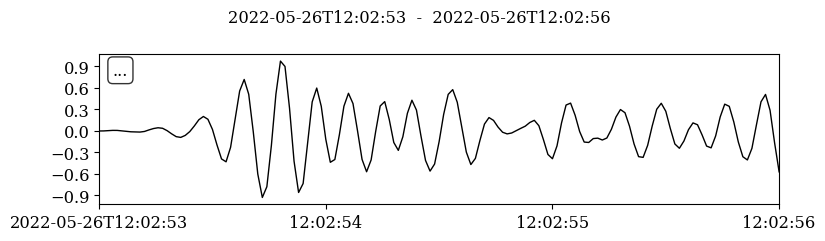

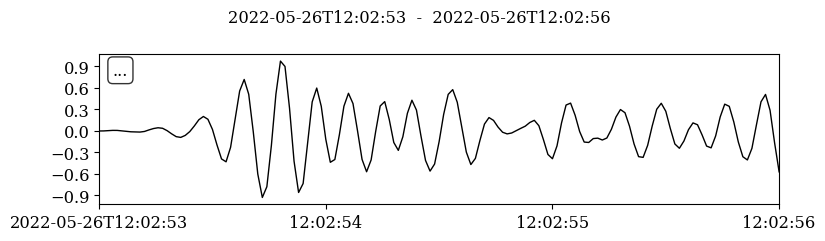

In [15]:
t = obs.Trace(data['waveforms'][1][0])
stamp = udt('2022-05-26T00:00:00').timestamp
t.stats.starttime = t.stats.starttime+stamp
t.stats.sampling_rate=50
start_plot = udt('2022-05-26T00:00:00') + (12*60*60) + (2*60) + 53
end_plot = start_plot + 3

t.plot(starttime=start_plot, endtime=end_plot)

<Figure size 2016x864 with 0 Axes>

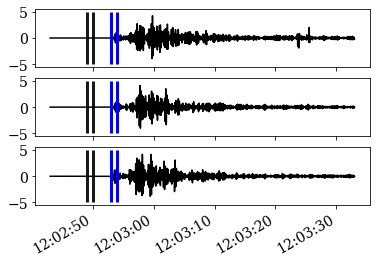

In [17]:
figsize = (28, 12)
plt.figure('template', figsize=figsize)

time = np.linspace(0., 1499, 2500)
id1 = (12*60*60*50) + (2*60*50) + (43*50)
id2 = id1 + 2500
start_date = udt('2022-05-26')
stamp = udt('2022-05-26T12:02:43').timestamp

de = data['waveforms'][1][0][id1:id2]
dn = data['waveforms'][1][1][id1:id2]
dz = data['waveforms'][1][2][id1:id2]
tre = obs.Trace(de)
tre.stats.starttime = tre.stats.starttime+stamp
tre.stats.sampling_rate = 50
trn = obs.Trace(dn)
trn.stats.starttime = trn.stats.starttime+stamp
trn.stats.sampling_rate = 50
trz = obs.Trace(dz)
trz.stats.starttime = trz.stats.starttime+stamp
trz.stats.sampling_rate = 50

#time = np.linspace(0., float(cc_sum.shape[1]) / data['metadata']['sampling_rate'], cc_sum.shape[1])
#smart_plot = np.abs(cc_sum[0, :]) > 2.5 * np.std(cc_sum[0, :])
#plt.plot(time[smart_plot]/3600, cc_sum[0, smart_plot], lw=0.5)
#plt.plot(datelist, cc_sum[0,:], lw=0.5)
#plt.axhline(0.45, lw=2, ls='--', color='k')
#plt.xlabel('Time (h)')
#plt.ylabel('Average correlation coefficient')
#plt.ylim(-0.3, 1.1)
#plt.xlim(time.min(), time.max()/3600)
#plt.title(data['metadata']['date'])
#plt.savefig(path_for_plots+'cc_sum_plots/'+magnitude_date_time_eq+'_'+dates_to_loop_over[i]+'_correlation_coefficients.png')

fig = plt.figure()
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(tre.times("matplotlib"), tre.data, "k-")
fig.autofmt_xdate()
ax1.xaxis_date()
ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(trn.times("matplotlib"), trn.data, "k-")
fig.autofmt_xdate()
ax2.xaxis_date()
ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(trz.times("matplotlib"), trz.data, "k-")
fig.autofmt_xdate()
ax3.xaxis_date()
fig.autofmt_xdate()#print(d, id1, id2, len(time))
ax1.set_xticklabels([])
ax2.set_xticklabels([])

stamp = stamp*1000000000
x_p = pd.to_datetime("2022-05-26T12:02:53.0")
x_p_d = pd.to_datetime("2022-05-26T12:02:54.0")

x_n = pd.to_datetime("2022-05-26T12:02:50.0")
x_n_d = pd.to_datetime("2022-05-26T12:02:49.0")

#ax3.v
#print(datetime(trz.times()[5])+stamp)
#plt.show()
xP = np.array([x_p, x_p_d])
#xS = np.array([S_time, S_time+duration])
xN = np.array([x_n, x_n_d])

y1 = np.array([5, 5])
y2 = np.array([-5, -5])

ax1.vlines(x_p, ymin=-5, ymax=5, color='blue', lw=3, alpha=1)
ax1.vlines(x_p_d, ymin=-5, ymax=5, color='blue', lw=3, alpha=1)

ax2.vlines(x_p, ymin=-5, ymax=5, color='blue', lw=3, alpha=1)
ax2.vlines(x_p_d, ymin=-5, ymax=5, color='blue', lw=3, alpha=1)

ax3.vlines(x_p, ymin=-5, ymax=5, color='blue', lw=3, alpha=1)
ax3.vlines(x_p_d, ymin=-5, ymax=5, color='blue', lw=3, alpha=1)


ax1.vlines(x_n, ymin=-5, ymax=5, color='black', lw=3, alpha=0.9)
ax1.vlines(x_n_d, ymin=-5, ymax=5, color='black', lw=3, alpha=0.9)

ax2.vlines(x_n, ymin=-5, ymax=5, color='black', lw=3, alpha=0.9)
ax2.vlines(x_n_d, ymin=-5, ymax=5, color='black', lw=3, alpha=0.9)

ax3.vlines(x_n, ymin=-5, ymax=5, color='black', lw=3, alpha=0.9)
ax3.vlines(x_n_d, ymin=-5, ymax=5, color='black', lw=3, alpha=0.9)


font = {'family': 'serif',
        'size': 14}
plt.rc('font', **font)
plt.show()

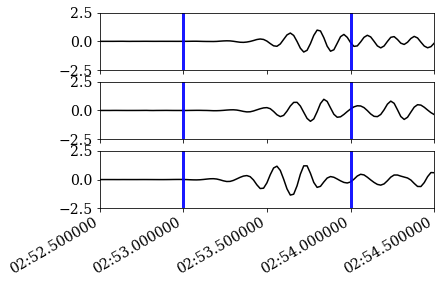

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(tre.times("matplotlib"), tre.data, "k-")
fig.autofmt_xdate()
ax1.xaxis_date()
ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(trn.times("matplotlib"), trn.data, "k-")
fig.autofmt_xdate()
ax2.xaxis_date()
ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(trz.times("matplotlib"), trz.data, "k-")
fig.autofmt_xdate()
ax3.xaxis_date()
fig.autofmt_xdate()#print(d, id1, id2, len(time))
ax1.set_xticklabels([])
ax2.set_xticklabels([])

xmax = pd.to_datetime("2022-05-26T12:02:54.5")
xmin = pd.to_datetime("2022-05-26T12:02:52.5")
yymin = -5
yymax = 5

stamp = stamp*1000000000
x_p = pd.to_datetime("2022-05-26T12:02:53.0")
x_p_d = pd.to_datetime("2022-05-26T12:02:54.0")
xP = np.array([x_p, x_p_d])
y1 = np.array([5, 5])
y2 = np.array([-5, -5])

ax1.vlines(x_p, ymin=yymin, ymax=yymax, color='blue', lw=3, alpha=0.9)
ax1.vlines(x_p_d, ymin=yymin, ymax=yymax, color='blue', lw=3, alpha=0.9)

ax2.vlines(x_p, ymin=yymin, ymax=yymax, color='blue', lw=3, alpha=0.9)
ax2.vlines(x_p_d, ymin=yymin, ymax=yymax, color='blue', lw=3, alpha=0.9)

ax3.vlines(x_p, ymin=yymin, ymax=yymax, color='blue', lw=3, alpha=0.9)
ax3.vlines(x_p_d, ymin=yymin, ymax=yymax, color='blue', lw=3, alpha=0.9)

ax1.set_xlim((xmin, xmax))
ax2.set_xlim((xmin, xmax))
ax3.set_xlim((xmin, xmax))
ax1.set_ylim((yymin/2, yymax/2))
ax2.set_ylim((yymin/2, yymax/2))
ax3.set_ylim((yymin/2, yymax/2))


font = {'family': 'serif',
        'size': 14}
plt.rc('font', **font)
plt.show()

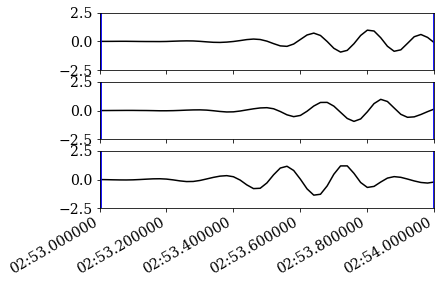

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(tre.times("matplotlib"), tre.data, "k-")
fig.autofmt_xdate()
ax1.xaxis_date()
ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(trn.times("matplotlib"), trn.data, "k-")
fig.autofmt_xdate()
ax2.xaxis_date()
ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(trz.times("matplotlib"), trz.data, "k-")
fig.autofmt_xdate()
ax3.xaxis_date()
fig.autofmt_xdate()#print(d, id1, id2, len(time))
ax1.set_xticklabels([])
ax2.set_xticklabels([])

xmax = pd.to_datetime("2022-05-26T12:02:54")
xmin = pd.to_datetime("2022-05-26T12:02:53")
yymin = -5
yymax = 5

stamp = stamp*1000000000
x_p = pd.to_datetime("2022-05-26T12:02:53.0")
x_p_d = pd.to_datetime("2022-05-26T12:02:54.0")
xP = np.array([x_p, x_p_d])
y1 = np.array([5, 5])
y2 = np.array([-5, -5])

ax1.vlines(x_p, ymin=yymin, ymax=yymax, color='blue', lw=3, alpha=0.9)
ax1.vlines(x_p_d, ymin=yymin, ymax=yymax, color='blue', lw=3, alpha=0.9)

ax2.vlines(x_p, ymin=yymin, ymax=yymax, color='blue', lw=3, alpha=0.9)
ax2.vlines(x_p_d, ymin=yymin, ymax=yymax, color='blue', lw=3, alpha=0.9)

ax3.vlines(x_p, ymin=yymin, ymax=yymax, color='blue', lw=3, alpha=0.9)
ax3.vlines(x_p_d, ymin=yymin, ymax=yymax, color='blue', lw=3, alpha=0.9)

ax1.set_xlim((xmin, xmax))
ax2.set_xlim((xmin, xmax))
ax3.set_xlim((xmin, xmax))
ax1.set_ylim((yymin/2, yymax/2))
ax2.set_ylim((yymin/2, yymax/2))
ax3.set_ylim((yymin/2, yymax/2))


font = {'family': 'serif',
        'size': 14}
plt.rc('font', **font)
plt.show()

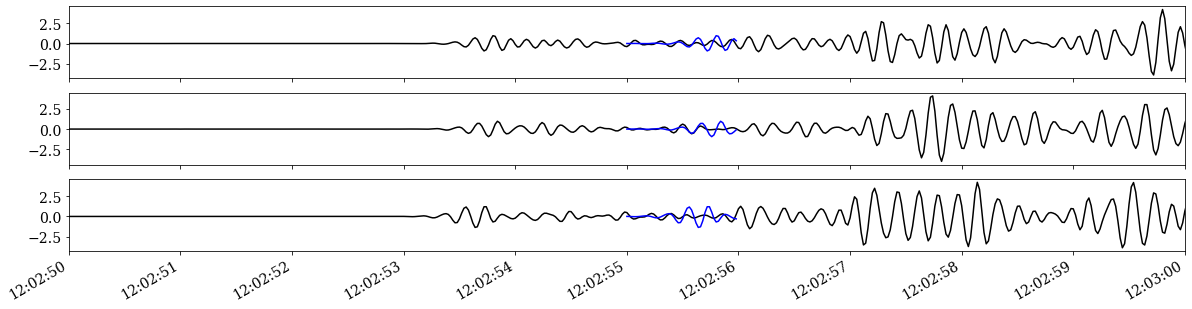

In [30]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(tre.times("matplotlib"), tre.data, "k-")
fig.autofmt_xdate()
ax1.xaxis_date()
ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(trn.times("matplotlib"), trn.data, "k-")
fig.autofmt_xdate()
ax2.xaxis_date()
ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(trz.times("matplotlib"), trz.data, "k-")
fig.autofmt_xdate()
ax3.xaxis_date()
fig.autofmt_xdate()#print(d, id1, id2, len(time))
ax1.set_xticklabels([])
ax2.set_xticklabels([])

xmax = pd.to_datetime("2022-05-26T12:03:00")
xmin = pd.to_datetime("2022-05-26T12:02:50")
yymin = -5
yymax = 5

ax1.set_xlim((xmin, xmax))
ax2.set_xlim((xmin, xmax))
ax3.set_xlim((xmin, xmax))


id1 = (12*60*60*50) + (2*60*50) + (53*50)
id2 = id1 + 50

t1 = obs.Trace(data['waveforms'][1][0][id1:id2])
t2 = obs.Trace(data['waveforms'][1][1][id1:id2])
t3 = obs.Trace(data['waveforms'][1][2][id1:id2])

t = [0, 6]

for i in t:
    i = t[1]
    st = udt('2022-05-26T12:02:50.0').timestamp
    st += i
    t1.stats.sampling_rate = 50
    t1.stats.starttime = t1.stats.starttime+st
    ax1.plot(t1.times("matplotlib"), t1.data, "b-")
    t2.stats.sampling_rate = 50
    t2.stats.starttime = t2.stats.starttime+st
    ax2.plot(t2.times("matplotlib"), t2.data, "b-")
    t3.stats.sampling_rate = 50
    t3.stats.starttime = t3.stats.starttime+st
    ax3.plot(t3.times("matplotlib"), t3.data, "b-")
    
    font = {'family': 'serif',
        'size': 14}
    plt.rc('font', **font)
    outfig = 'fig_' + str(i) + '.png'
    fig.savefig(outfig)

In [12]:
dz = cc_sum[0, :]
trz = obs.Trace(dz)
trz.stats.sampling_rate = 50
stamp = udt('2022-05-26T00:00:00').timestamp
trz.stats.starttime = trz.stats.starttime + stamp



(738301.5019675926, 738301.5020833333)

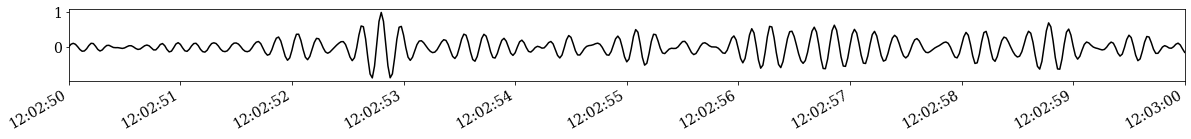

In [228]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(trz.times("matplotlib"), trz.data, "k-")
fig.autofmt_xdate()
ax1.xaxis_date()
ax1.set_xlim((xmin, xmax))

In [247]:
t = ["2022-05-26T12:02:57.2"]
k = 0
stamp = udt('2022-05-26T00:00:00').timestamp
trz.stats.starttime = trz.stats.starttime
trz.stats.sampling_rate = 50
x_p1 = pd.to_datetime(t[0])
x_dates = pd.to_datetime(trz.times()[:]*1000000000 + udt("2022-05-26T00:00:00").timestamp*1000000000)
id_x = np.where(x_p1 == x_dates)
val = trz.data[id_x]
print(val)
if val < 0:
    ax1.scatter(x_p1, y=val, color='blue', marker='.', markersize=20)
else:
    ax1.scatter(x_p1, y=val, color='blue', marker='.', markersize=20)
outname = 'corr_' + str(k) + '.png' 
fig.savefig(outname)


[0.36523718]


AttributeError: 'PathCollection' object has no property 'markersize'

In [166]:
print(len(cc_sum[0]),len(data['waveforms'][0][0]))

4319852 4319951
